In [7]:
### Link to Github Repo with the same code: ###
### https://github.com/dylan-losey/me5824.git ###

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np

In [8]:
### Create our BC Model ###

class HumanData(Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx])


class BC(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(BC, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim

        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, action_dim)

        self.loss_func = nn.MSELoss()

    def encoder(self, state):
        h1 = torch.tanh(self.linear1(state))
        h2 = torch.tanh(self.linear2(h1))
        return self.linear3(h2)

    def forward(self, x):
        state = x[:, :self.state_dim]
        a_target = x[:, -self.action_dim:]
        a_predicted = self.encoder(state)
        loss = self.loss(a_predicted, a_target)
        return loss

    def loss(self, a_predicted, a_target):
        return self.loss_func(a_predicted, a_target)

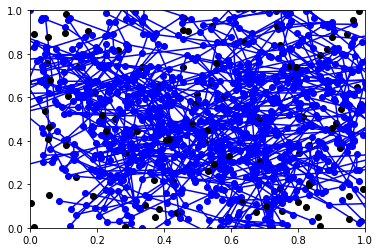

In [9]:
### Collect the human demonstrations ###

N = 100             # number of demonstrations
sigma_h = 0.1       # amount of noise in the demonstration
T = 10              # each demonstration has T timesteps
D = []              # dataset of state-action pairs
for iter in range(N):
    xi = np.zeros((T, 2))
    p_robot = np.random.rand(2)
    p_goal = np.random.rand(2)
    for timestep in range(T):
        a = np.random.normal((p_goal - p_robot) / 5.0, sigma_h)
        xi[timestep, :] = np.copy(p_robot)
        D.append(p_robot.tolist() + p_goal.tolist() + a.tolist())
        p_robot += a
    plt.plot(p_goal[0], p_goal[1], 'ko')
    plt.plot(xi[:,0], xi[:,1], 'bo-')
plt.axis([0, 1, 0, 1])
plt.show()

In [10]:
### Train the BC Model ###

# arguments: state dimension, action dimension, hidden size
model = BC(4, 2, 32)

EPOCH = 1001
BATCH_SIZE_TRAIN = 100
LR = 0.01
LR_STEP_SIZE = 360
LR_GAMMA = 0.1

train_data = HumanData(D)
train_set = DataLoader(dataset=train_data, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)

for epoch in range(EPOCH):
  for batch, x in enumerate(train_set):
      optimizer.zero_grad()
      loss = model(x)
      loss.backward()
      optimizer.step()
  scheduler.step()
  if epoch % 100 == 0:
    print(epoch, loss.item())
torch.save(model.state_dict(), "bc_weights")

0 0.012601804919540882
100 0.010716089978814125
200 0.008722607977688313
300 0.00932472012937069
400 0.009899144992232323
500 0.010061867535114288
600 0.007867575623095036
700 0.007763720117509365
800 0.00921557191759348
900 0.009392079897224903
1000 0.00913394894450903


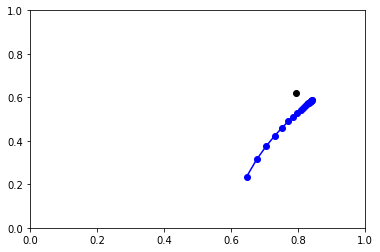

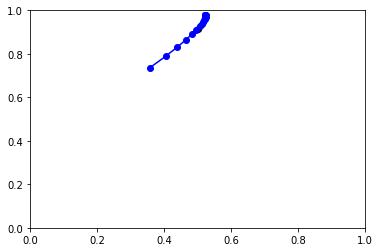

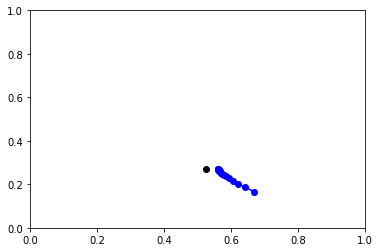

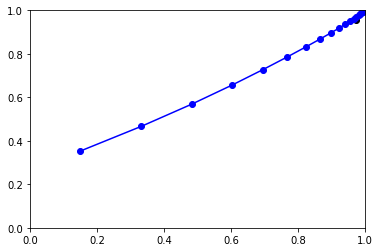

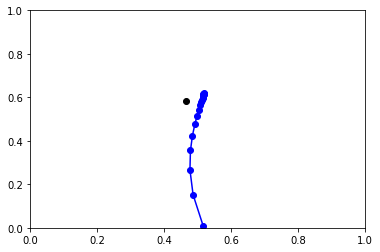

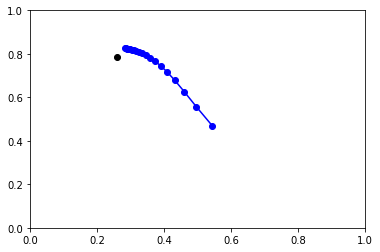

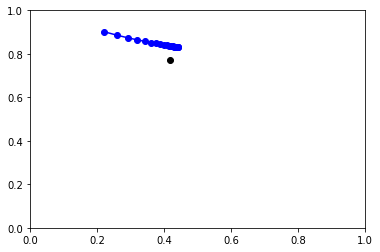

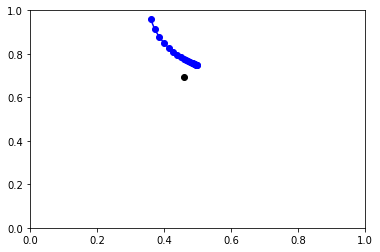

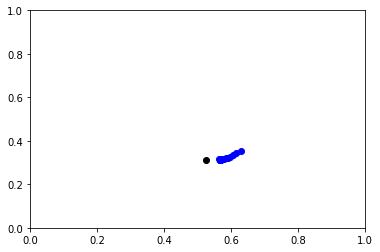

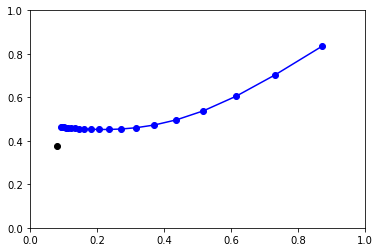

In [11]:
### Rollout the trained model ###

model = BC(4, 2, 32)
model.load_state_dict(torch.load("bc_weights"))


N = 10          # number of rollouts
T = 20          # each one has T timesteps
for iter in range(N):
    xi = np.zeros((T, 2))
    p_robot = np.random.rand(2)
    p_goal = np.random.rand(2)
    for timestep in range(T):
        context = np.concatenate((p_robot, p_goal))
        a = model.encoder(torch.Tensor(context)).detach().numpy()
        xi[timestep, :] = np.copy(p_robot)
        p_robot += a
    plt.plot(p_goal[0], p_goal[1], 'ko')
    plt.plot(xi[:,0], xi[:,1], 'bo-')
    plt.axis([0, 1, 0, 1])
    plt.show()
